In [272]:
# imports
import pandas as pd
import numpy as np
import os

In [273]:
import kagglehub
path = kagglehub.dataset_download("fatemehmehrparvar/obesity-levels")
csv_file_path = os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv") 
print("Path to dataset files:", path)

Path to dataset files: /Users/kierstenwener/.cache/kagglehub/datasets/fatemehmehrparvar/obesity-levels/versions/1


In [274]:
df = pd.read_csv(csv_file_path) #can infer col names
df.head()


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [276]:
num_classes = df['FAVC'].nunique()
print(f'Num classes {num_classes}')

Num classes 2


In [277]:
drink = df['TUE'].value_counts()
print(drink)

TUE
0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
1.343044      1
1.019452      1
0.673408      1
0.997600      1
0.714137      1
Name: count, Length: 1129, dtype: int64


In [278]:
class_distrib = df['NObeyesdad'].value_counts()
print(class_distrib)

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


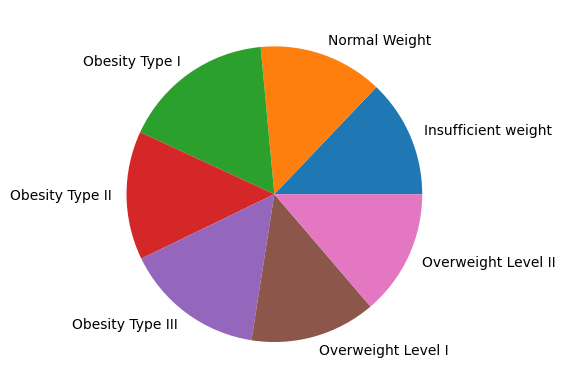

In [279]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tmp = LabelEncoder()
y= tmp.fit_transform(df['NObeyesdad'])
class_labels = np.array(['Insufficient weight', 'Normal Weight', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III', 'Overweight Level I', 'Overweight Level II'])
counts = np.bincount(y)
plt.pie(counts, labels = class_labels)
plt.show()

In [280]:
print(tmp.classes_)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [281]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.drop('NObeyesdad', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

You have to scale and encode after splitting i believe. if you dont, the encoder/scaler will also learn from the test data which should not happen. 

In [282]:
from sklearn.preprocessing import OneHotEncoder
#there are other numeric attributes, but they are discrete, not continuous 
#age, height, weight, NCP (num of meals per day), CH20 (how much water you drink daily), and FAF (how ofetn exercise) are the continuous numeric columns
#there are other numeric attributes, but they are discrete, not continuous 
scaler = StandardScaler()
cont_indices = [0, 2, 3, 7, 10, 12]
categorical_index = [i for i in range(X.shape[1]) if i not in cont_indices]
print("Number of columns in X:", X.shape[1])  # Ensure the number of columns in X is as expected
print("Continuous column indices:", cont_indices)

X = X.to_numpy()
X_scale = scaler.fit_transform(X[:, cont_indices])
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
X_encoded = encoder.fit_transform(X[:, categorical_index])
X = np.hstack([X_scale, X_encoded])

#split for validation
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=1)
print(X.shape)
#Here, i fit the scaler only on the training data. I then apply that same scale on testing data. 
#This way, the X_test data doesnt change the scale that the data is scaled on, to prevent data snooping 
#X_train.iloc[:, cont_indices] = scaler.fit_transform(X_train.iloc[:, cont_indices])
#X_test.iloc[:, cont_indices] = scaler.transform(X_test.iloc[:, cont_indices])



# One-hot encoding for categorical features
#encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
#X_train_cat_encoded = encoder.fit_transform(X_train[categorical_index])
#X_test_cat_encoded = encoder.transform(X_test[categorical_index])
#X_encoded = encoder.transform(X[categorical_index])

# Concatenate scaled continuous and encoded categorical features
#X_train= np.hstack([X_train.iloc[:, cont_indices], X_train_cat_encoded])
#X_test_final = np.hstack([X_test.iloc[:, cont_indices], X_test_cat_encoded])
#X= np.hstack([X_scale.iloc[:, cont_indices], X_encoded])

Number of columns in X: 16
Continuous column indices: [0, 2, 3, 7, 10, 12]
(2111, 1958)


dimensions are too large after one hot encoding, do PCA

At the end of preprocessing, the categorical variables are one hot encoded, the continuous variables are scaled, the target variable was integer encoded, and pca was done to reduce the number of features from 1567 to 200. This dataset is used for classification, as because the target variable is a categorical variable. The other attributes in the data set will be used to classify the tuple by one of the labels (classes of the target variable). These include 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II', 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II'.

In a business application, this classification model could be used for ....

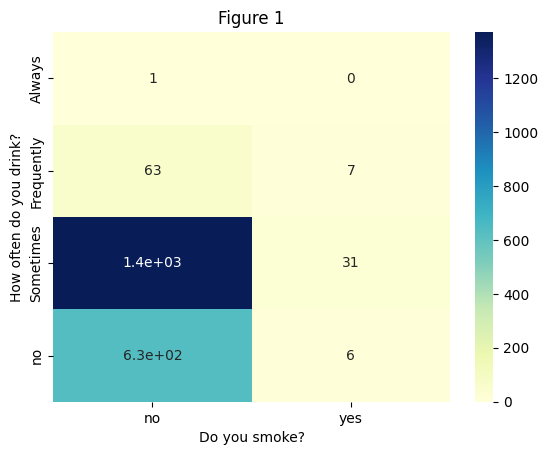

In [283]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['CALC'], df['SMOKE'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you smoke?')
plt.ylabel('How often do you drink?')
plt.title('Figure 1')
plt.show()

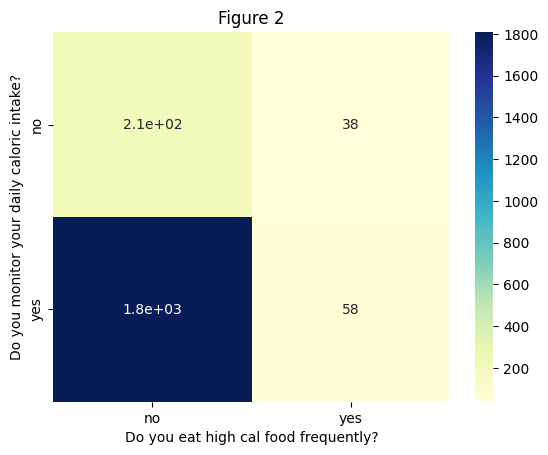

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['FAVC'], df['SCC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Do you monitor your daily caloric intake?')
plt.title('Figure 2')
plt.show()

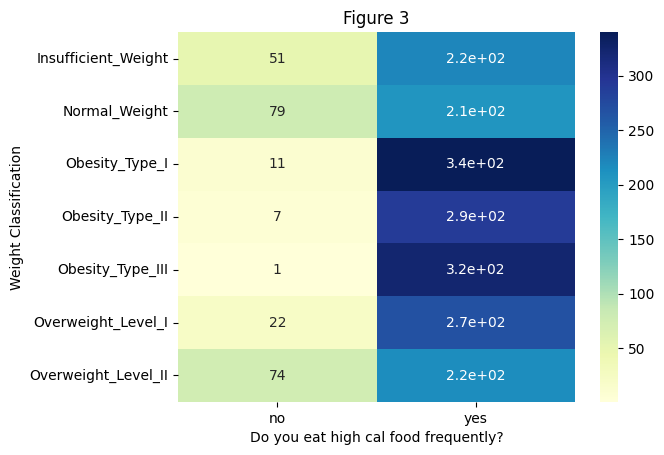

In [285]:
contingency_table = pd.crosstab(df['NObeyesdad'], df['FAVC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Weight Classification')
plt.title('Figure 3')
plt.show()

https://developers.google.com/machine-learning/crash-course/categorical-data/feature-crosses

Try not to cross two sparse features, this would create a new sparser feature than the original elements 

I would recommend crossing SMOKE (Binary, do you smoke?) and CALC (How often do you drink alcohol with answer options including no, sometimes, frequently, always). Each of these features has a small number of classes, which will make computations easy. They are also pretty correlated. As you can see by the heatmap above (Figure 1), If a person does not smoke, it is highly likely that they either dont drink, or that they only drink sometimes. This combination captures the interaction between lifestyle patterns (smoking and drinking) that could be valuable in predicting other health ..., like if a person is obese.


I would also recommend crossing FAVC (Binary question:Do you eat high caloric food frequently? ) and SCC (Binary question, do you monitor the calories you eat daily?). Each is a binary question, meaning they will each have a yes or no answer, which makes the crossed feature simple. They also have a correlation. As you can see above, if a person does not eat high calorie food frequently, it is likely that they also monitor their caloric intake. This captures the interaction between a person being conscious of they caloric intake, and ...., its health consequences, and if a person eats high calorie food often. This interaction can provide useful insights to a person being conscious of their diet and its correlation with obesity, If a person is conscious about their health in a way that causes them to not eat high calorie foods, it is likely that they are conscious of/monitor their daily calorie intake. These two factors logically influence eachother, so it makes sense to combine them. 





///
Because the dataset it realtively small, it could be benefitical to cross categories that create classes with realtively similar sample sizes in each. This helps to avoid sparsity in the new categories, which can improve the generalization abilities of the model. I believe that it is more important for this model to capture charactistics of the subject, instead of the correlation between two of their attributes. 
///

If a person eats high caloric food frequently (FAVC) and has a family history of obesity (family_history_with_overweight), it greatly influences the odds that the person is obese, which is the classification task at hand. This is why it may be beneficial to combine family_history_with_overweight and FAVC. In Figure 2, you can also see a correlation between the variables. If a person has a family history of obesity, it is more likely that they eat high calorie food frequently. People often adpot the lifestyle habits that they observed growing up. If a person's family eats high calorie food growing up, which is HIGHLY correlated with obesity, it is likely that they will have similar dietary habits, and face similar consequences (Figure 3). 



This model performs a classifies a person by their obesity level based on attributes like gender, age, their lifestyle choices (if they drink/smoke and their ... sedintary), their diet, etc. In a business scenario, this model could be used by doctors offices (general practitioners/weight loss specialists) to predict if a person is at risk for being obese, and recommend lifestyle changes accordingly. Obesity can lead to serious health conseuqences, like heart disease, cancer, and type 2 diabetes, all of which can be fatal. If a person is on track to... obesity and the model fails to catch it, it could prevent a person from getting the intervention that they need to preserve their health. However, if the model misclassifies a person as obese when they are not, the recommended lifestyle changes wouldn't have a negative impact on the person. That being said false negatives have more serious implications than false positives. Because of this, we should use the recall metric. The recall metric measures the number of false negatives (the higher the recall, the lower the number of false neg), so we can be sure that our model is performing properly for the business application that we have in mind. 

To evaluate this algorithm's performance, 

#https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv#:~:text=KFold%20will%20divide%20your%20data,set%20and%20a%20test%20set.
use stratified for unbalanced


Based on the graph above the the figures above, we see that the data is realatively balanced. there is a relatively equal number of each class of the target variable in the data set. Even still, I will use stratified K-Fold to split the data. This will ensure that the folds maintain the original distribution of classes in the data to make sure that all of the classes are represented correctly.

The difference between kfold and shufflesplit is that kfold divides the data into a specific number of folds (each of which is a subset of the dataset) and shufflesplit randomly takes samples from your whole dataset to make a train and test set at each iteration. With shufflesplit, the test sets can overlap, where in kfold, they cant. To prevent overlap and any bias, I will use the kfold method. This also ensures that each data point will be used for testing, whereas in shufflesplit, it is possible that a datapoint will not be used for testing at all. The dataset is also on the smaller side with 2111 samples, so kfold won't be too computationally expensive and can be used. 

In [286]:
#have to split the data into testing and training before one hot encoding, normalizing, dimensionality reduction etc to prevent dats snooping
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Initialize stratified k-fold

pipe_rf = Pipeline([
                    ('pca', PCA(n_components=30,random_state=1)),
                    ('clf', RandomForestClassifier( random_state=1))])
# List to hold accuracy scores

kfold_for_validation = StratifiedKFold(n_splits=10).split(X_train1, y_train1)

scores = []
for k, (train, test) in enumerate(kfold_for_validation):
    pipe_rf.fit(X_train1[train], y_train1[train])
    score = pipe_rf.score(X_train1[test], y_train1[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.858
Fold: 2, Acc: 0.876
Fold: 3, Acc: 0.899
Fold: 4, Acc: 0.852
Fold: 5, Acc: 0.870
Fold: 6, Acc: 0.852
Fold: 7, Acc: 0.876
Fold: 8, Acc: 0.870
Fold: 9, Acc: 0.869
Fold: 10, Acc: 0.863

CV accuracy: 0.868 +/- 0.013


In [287]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_rf,
                         X=X_train1,
                         y=y_train1,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.85798817 0.87573964 0.89940828 0.85207101 0.86982249 0.85207101
 0.87573964 0.86982249 0.86904762 0.86309524]
CV accuracy: 0.868 +/- 0.013


In [288]:
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

In [290]:
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_rf,
                                                       X=X_train1,
                                                       y=y_train1,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=5,
                                                       n_jobs=-1)

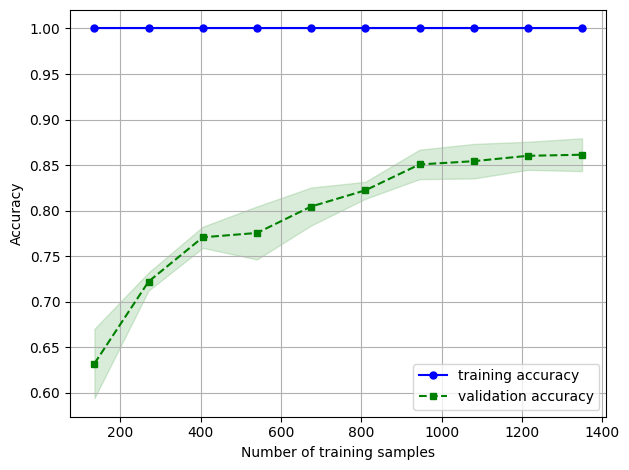

In [ ]:
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

Shows that it is overlearned

In [291]:
from sklearn.model_selection import validation_curve


param_name = 'clf__max_depth'
param_range = [5, 10, 15, 20]
train_scores, test_scores = validation_curve(
                estimator=pipe_rf, 
                X=X_train1, 
                y=y_train1, 
                param_name=param_name,
                param_range=param_range,
                cv=5,n_jobs=-1)

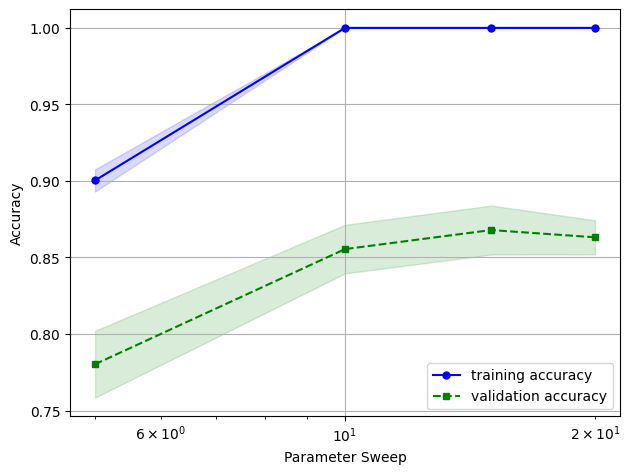

In [292]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

The blue line represents the mean training accuracy across the cross validation for each of the values of max depth (the max depth of each tree). There is supposed to be a blue shading around it that represents 1 standard deviation from the mean. The high/stable training accuracy across folds that we see with the horizonal line at 1 indicates that the model fits the training data well.

The green line represents the mean validation accuracy across all folds for each max depth param. The shaded area shows the variability in the validation accuracy. The green line is lower than the blue line, but not significantly enough that we have to worry about overfitting. As far as parameter, I will choose 15, since that is where validation accuraxy seems stable

Start kfold split on whole dataset, not just for validation
this is to be used in the modeling

In [293]:
kfold_for_validation = StratifiedKFold(n_splits=10).split(X, y)

In [300]:
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import sys


ModuleNotFoundError: No module named 'distutils'